# Supervised Learning: Regression (Time Series)
---

# ***Autoregressive Integrated Moving Average* (ARIMA) Model for Time Series Forecasting**

Referensi:
- https://www.ibm.com/topics/supervised-learning
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html
- https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp

## Import Library

In [5]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime as dt

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Machine Learning
import sklearn as sk
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Iterator
import itertools

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)
print('Scikit-Learn', sk.__version__)

NumPy 1.23.5
Pandas 2.0.1
Matplotlib 3.7.1
Seaborn 0.12.2
Scikit-Learn 1.2.2


## Read Dataset

In [8]:
# Read the data files
data = pd.read_csv('https://raw.githubusercontent.com/sabirinID/Kalbe-Nutritionals-Data-Science/main/Dataset/Cleaned_Data.csv')

In [9]:
data.sample(5)

,CustomerID,Age,Gender,MaritalStatus,Income,ProductID,ProductName,Price,StoreID,StoreName,Group,Type,Latitude,Longitude,TransactionID,Date,Quantity,TotalAmount
1245,151,42,0,1,10.38,P7,Coffee Candy,9400,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,TR41376,2022-03-13,4,37600
1609,372,31,1,1,6.19,P7,Coffee Candy,9400,7,Buana Indah,Buana,General Trade,3.316694,114.590111,TR24012,2022-06-19,4,37600
3790,442,42,1,1,14.88,P9,Yoghurt,10000,8,Sinar Harapan,Harapan Baru,General Trade,5.548290,95.323753,TR88217,2022-01-10,1,10000
3344,246,40,1,0,21.81,P5,Thai Tea,4200,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238,TR61579,2022-04-29,2,8400
3655,380,40,0,1,5.77,P8,Oat,16000,8,Sinar Harapan,Harapan Baru,General Trade,5.548290,95.323753,TR34922,2022-02-06,1,16000


In [10]:
data.shape

(5020, 18)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     5020 non-null   int64  
 1   Age            5020 non-null   int64  
 2   Gender         5020 non-null   int64  
 3   MaritalStatus  5020 non-null   int64  
 4   Income         5020 non-null   float64
 5   ProductID      5020 non-null   object 
 6   ProductName    5020 non-null   object 
 7   Price          5020 non-null   int64  
 8   StoreID        5020 non-null   int64  
 9   StoreName      5020 non-null   object 
 10  Group          5020 non-null   object 
 11  Type           5020 non-null   object 
 12  Latitude       5020 non-null   float64
 13  Longitude      5020 non-null   float64
 14  TransactionID  5020 non-null   object 
 15  Date           5020 non-null   object 
 16  Quantity       5020 non-null   int64  
 17  TotalAmount    5020 non-null   int64  
dtypes: float

In [12]:
data.columns

Index(['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'Income', 'ProductID',
       'ProductName', 'Price', 'StoreID', 'StoreName', 'Group', 'Type',
       'Latitude', 'Longitude', 'TransactionID', 'Date', 'Quantity',
       'TotalAmount'],
      dtype='object')

In [10]:
data_regression = data[['Date', 'Quantity']].copy()

# Convert 'Date'
# data_regression['Date'] = pd.to_datetime(data_regression['Date'])

# Group by 'Date' and .sum() the 'Quantity' column
data_regression = data_regression.groupby('Date')['Quantity'].sum()

# Rename the columns for clarity
data_regression = data_regression.rename('TotalQuantity')

In [11]:
data_regression.head()

Date
2022-01-01    49
2022-01-02    59
2022-01-03    63
2022-01-04    45
2022-01-05    30
Name: TotalQuantity, dtype: int64

In [12]:
data_regression.name, data_regression.shape

('TotalQuantity', (365,))

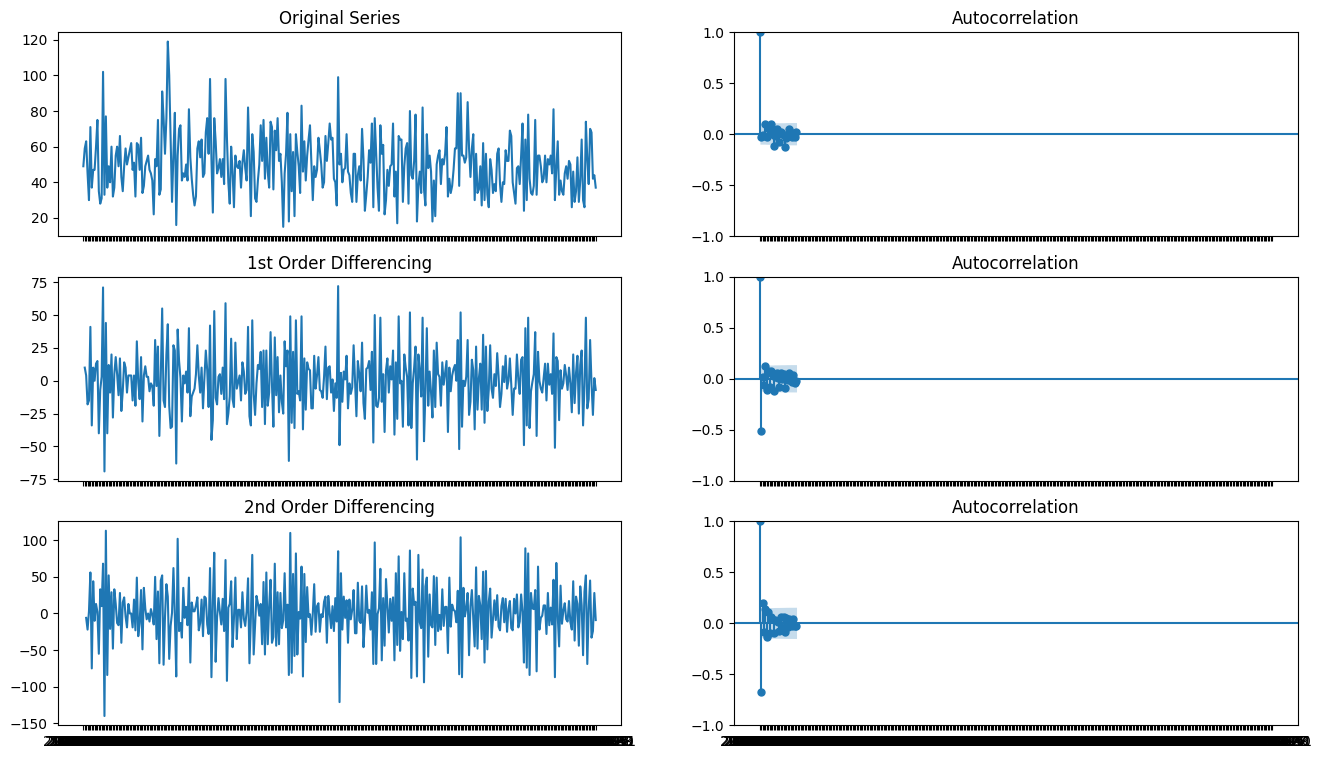

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(16, 9)})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_regression); axes[0, 0].set_title('Original Series')
plot_acf(data_regression, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_regression.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_regression.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_regression.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_regression.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Patterns in a Time Series

In [14]:
# Convert 'data_regression' Series to DataFrame
data_reg = data_regression.to_frame()
data_reg.head()

,TotalQuantity
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30


In [15]:
# Transform data
data_log = np.log(data_reg)
data_log.head()

,TotalQuantity
Date,
2022-01-01,3.891820
2022-01-02,4.077537
2022-01-03,4.143135
2022-01-04,3.806662
2022-01-05,3.401197


- Log-transformasi dapat digunakan untuk mengatasi ketidakstabilan variansi (heteroskedastisitas) dan memastikan data yang memiliki sifat eksponensial dapat dimodelkan dengan lebih baik.

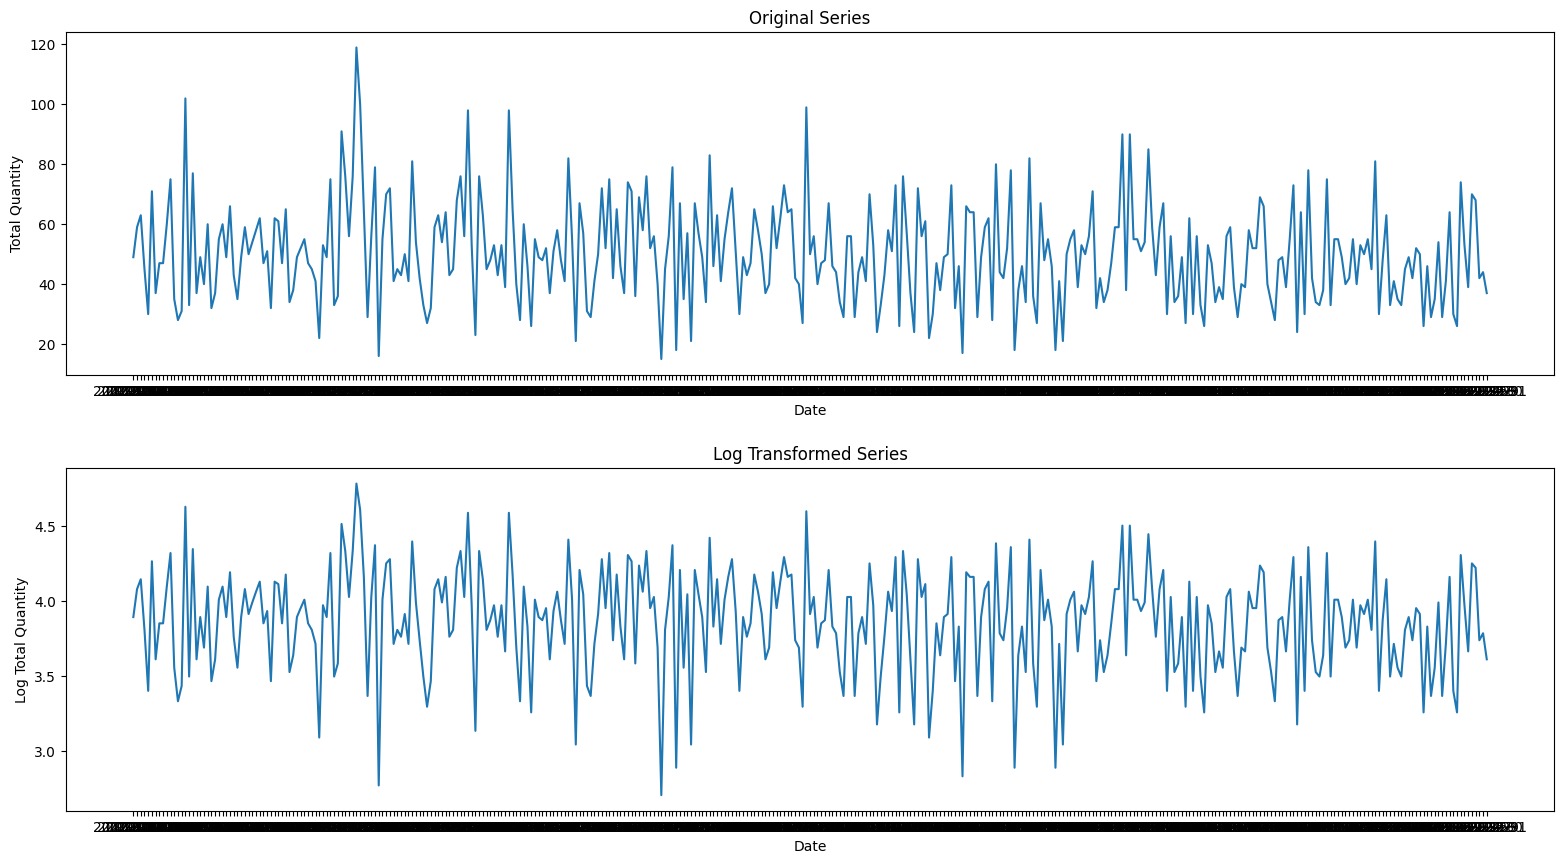

In [16]:
plt.figure(figsize=(16, 9))

# First Subplot - data_reg
plt.subplot(2, 1, 1)
plt.plot(data_reg)
plt.title('Original Series')
plt.xlabel('Date')
plt.ylabel('Total Quantity')

# Second Subplot - data_log
plt.subplot(2, 1, 2)
plt.plot(data_log)
plt.title('Log Transformed Series')
plt.xlabel('Date')
plt.ylabel('Log Total Quantity')

plt.tight_layout(pad=2)
plt.show()

### Decomposition of a Time Series

<Figure size 1600x1200 with 0 Axes>

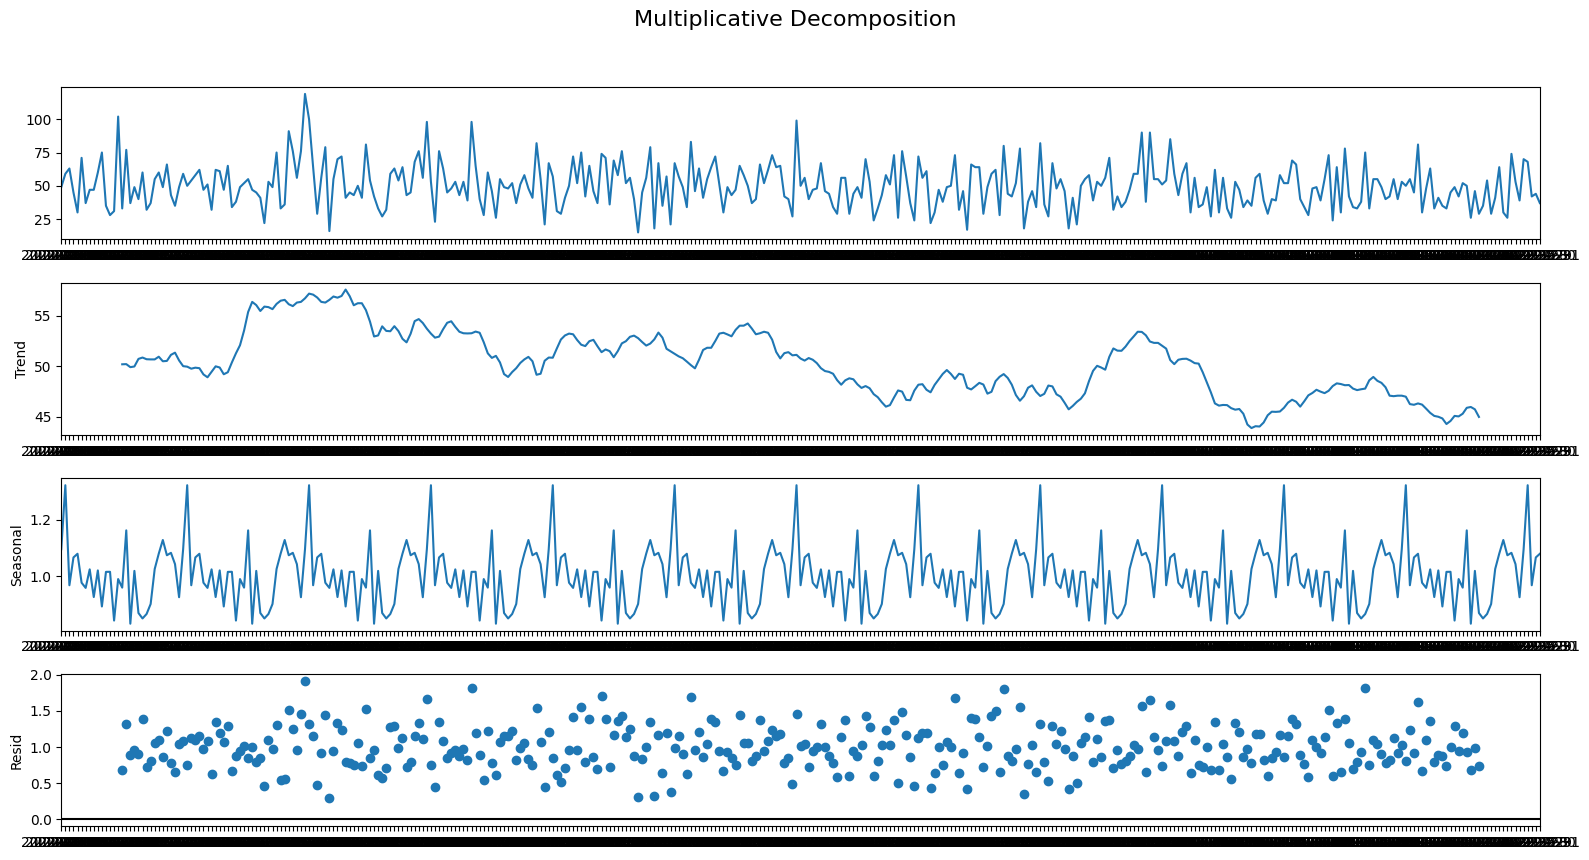

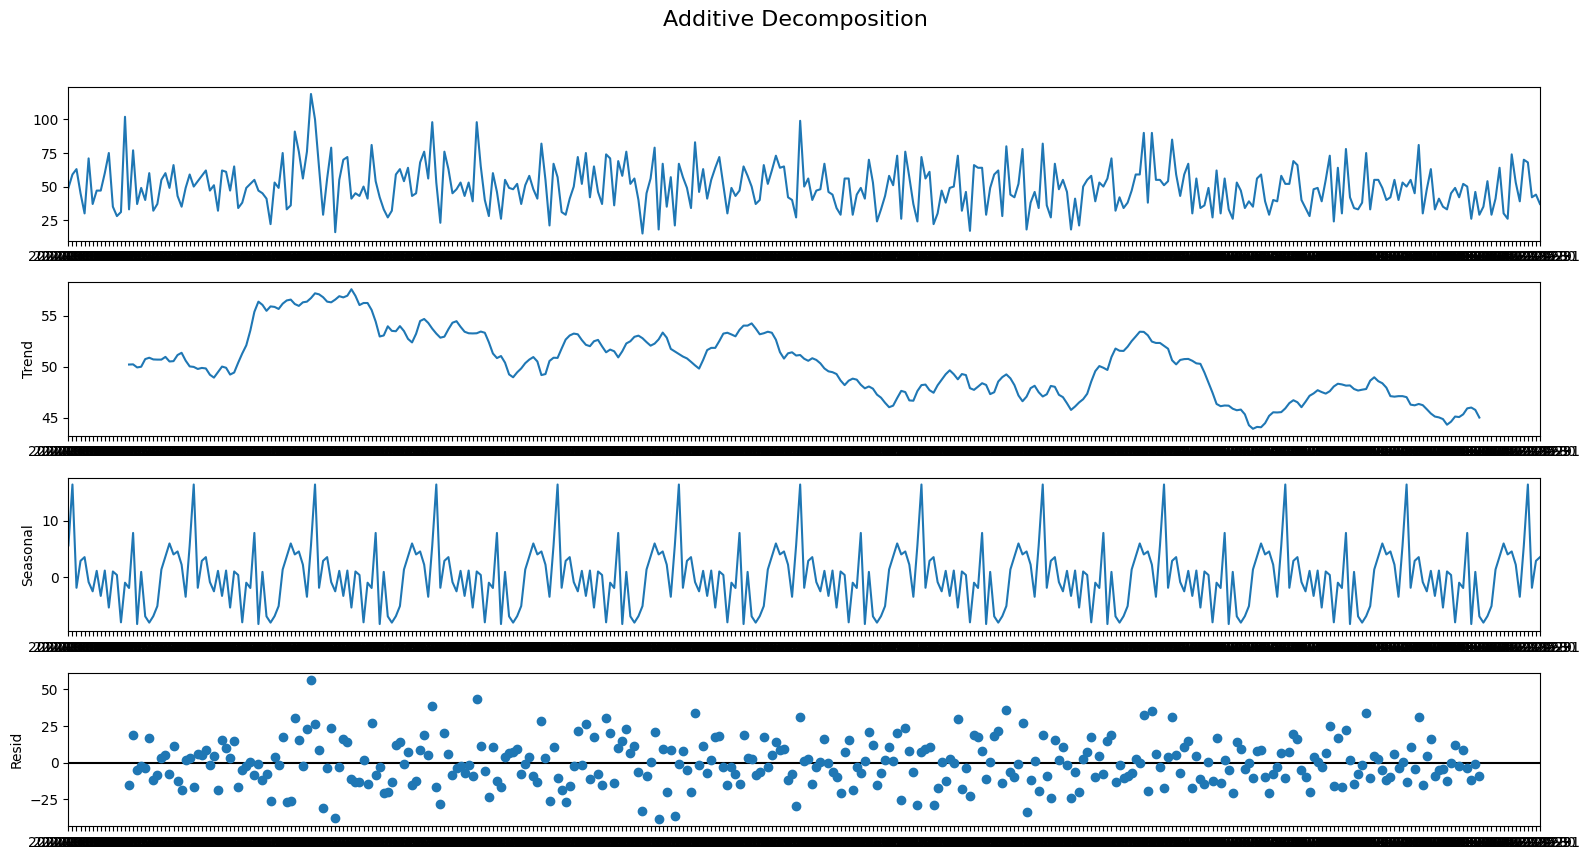

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(data_reg, model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(data_reg, model='additive', period=30)

# Plot
plt.figure(figsize=(16, 12))
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Stationary and Non-Stationary Time Series

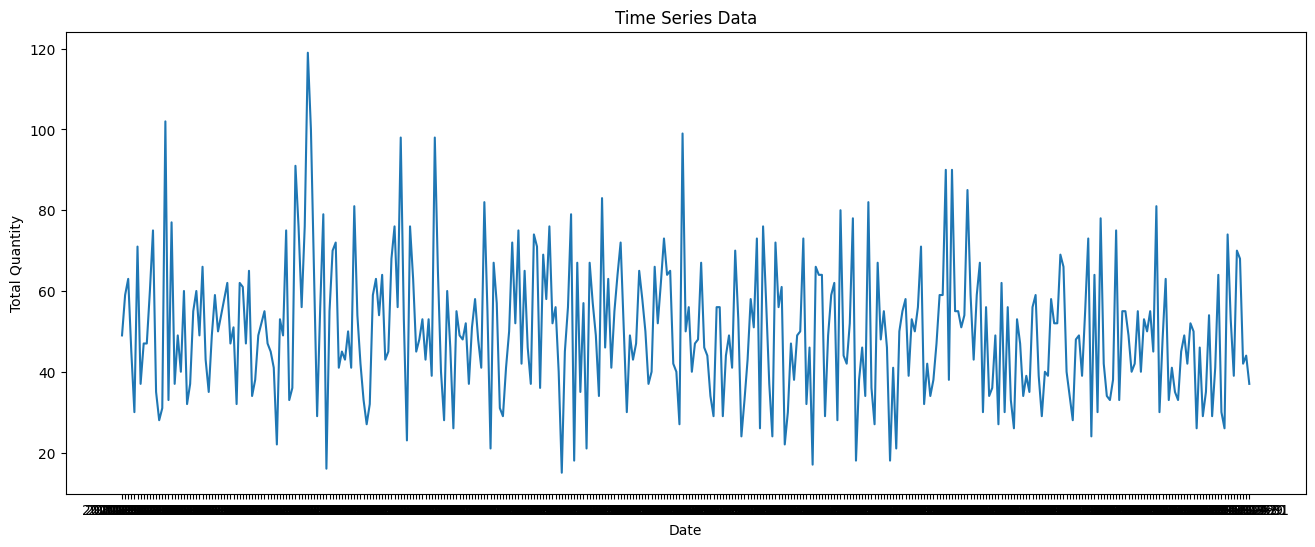

Augmented Dickey-Fuller Test:
ADF Statistic: -19.448086319449082
p-value: 0.0
Critical Values:
   1%: -3.4484434475193777
   5%: -2.869513170510808
   10%: -2.571017574266393


In [18]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller Test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# The time series data
time_series_data = data_reg

# Plot
plt.figure(figsize=(16, 6))
plt.plot(time_series_data)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.show()

# Perform Augmented Dickey-Fuller Test
print('Augmented Dickey-Fuller Test:')
adf_test(time_series_data)

🔎 Observasi
- Berdasarkan hasil Augmented Dickey-Fuller Test, menunjukkan bahwa secara keseluruhan, time series tersebut dapat dianggap sebagai stationary, karena
  - *ADF statistic* lebih kecil daripada nilai kritis pada tingkat signifikansi 1%, 5%, dan 10%.
  - P-value kurang dari tingkat signifikansi 0,05.

### Detrend a Time Series

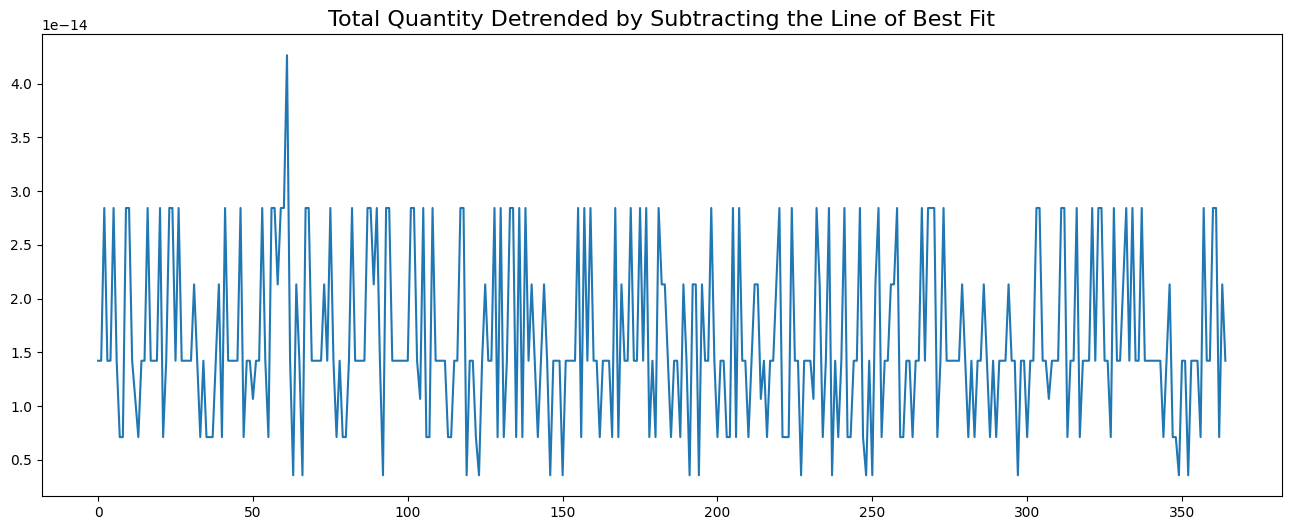

In [19]:
from scipy import signal

# Detrend
detrended = signal.detrend(data_reg.values)

# Plot
plt.figure(figsize=(16, 6))
plt.plot(detrended)
plt.title('Total Quantity Detrended by Subtracting the Line of Best Fit', fontsize=16)

plt.show()

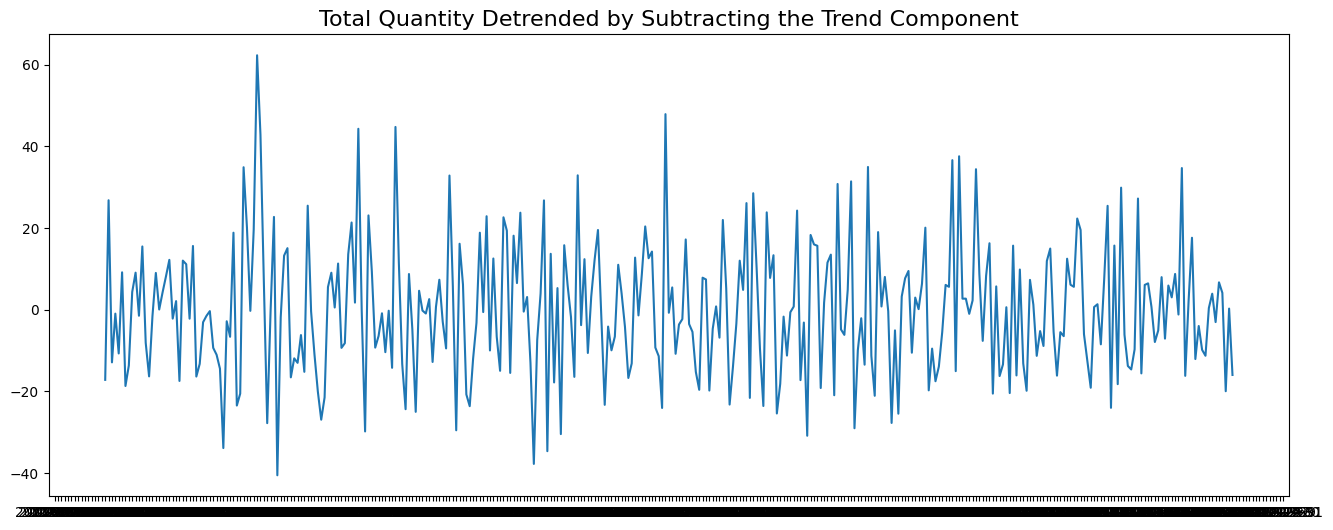

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_multi = seasonal_decompose(data_reg['TotalQuantity'], model='multiplicative', period=30)
# Detrend
detrended = data_reg['TotalQuantity'].values - result_multi.trend

# Plot
plt.figure(figsize=(16, 6))
plt.plot(detrended)
plt.title('Total Quantity Detrended by Subtracting the Trend Component', fontsize=16)

plt.show()

### Deseasonalize a Time Series

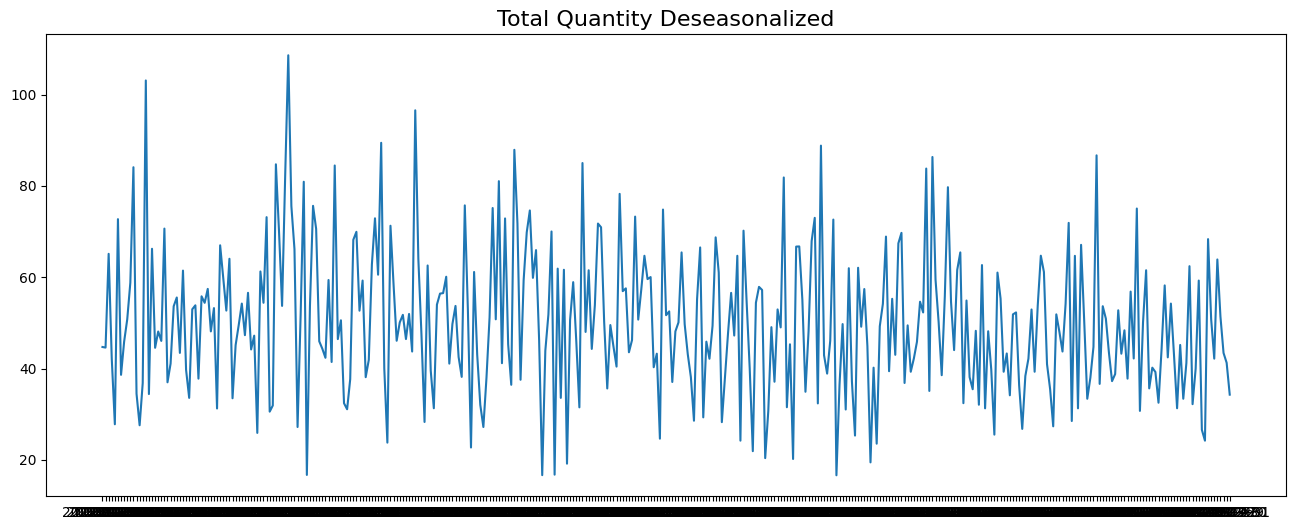

In [21]:
result_multi = seasonal_decompose(data_reg['TotalQuantity'], model='multiplicative', period=30)
# Deseasonalize
deseasonalized = data_reg['TotalQuantity'].values / result_multi.seasonal

# Plot
plt.figure(figsize=(16, 6))
plt.plot(deseasonalized)
plt.title('Total Quantity Deseasonalized', fontsize=16)

plt.show()

### Autocorrelation and Partial Autocorrelation Functions

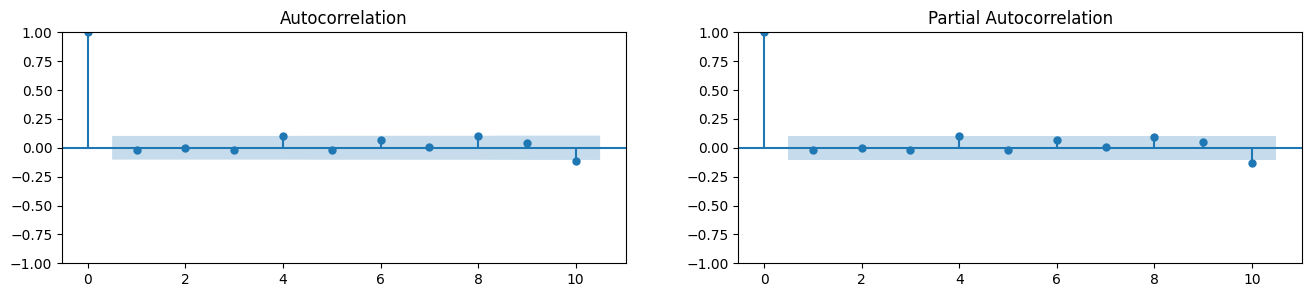

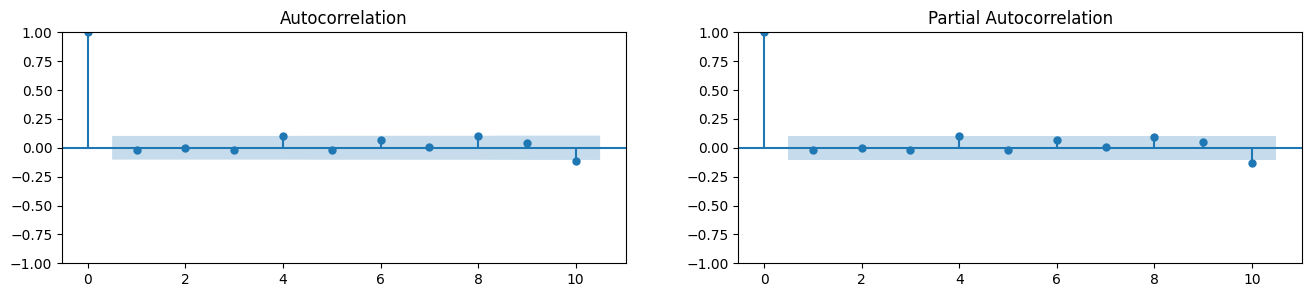

In [22]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

# Autocorrelation
plot_acf(data_reg['TotalQuantity'].tolist(), lags=10, ax=axes[0])

# Partial Autocorrelation
plot_pacf(data_reg['TotalQuantity'].tolist(), lags=10, ax=axes[1])

## Modeling and Evaluation

In [23]:
series = data_reg
# series = data_log

In [24]:
# Split data into train and test sets
train = series.iloc[:-31]
test = series.iloc[-31:]

In [25]:
train.shape, test.shape

((334, 1), (31, 1))

### Parameter Analysis for the ARIMA Model

#### Auto-ARIMA

In [26]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00


In [27]:
import pmdarima as pm

auto_arima = pm.auto_arima(series,
                           start_p=1, start_q=1, # Starting values for p and q
                           test='adf',           # Use adftest to find optimal 'd'
                           max_p=3, max_q=3,     # Maximum values for p and q
                           m=12,                 # Frequency of the time series
                           d=None,               # Let model determine 'd'
                           D=0,                  # Seasonal order of differencing
                           seasonal=False,       # No Seasonality
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3102.254, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3933.778, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3338.359, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3695.934, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3103.765, Time=0.73 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3103.744, Time=0.65 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3559.851, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3244.148, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3098.081, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3096.077, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3094.267, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3096.079, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 3.294 seconds
                           

In [28]:
auto_arima

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

🔎 Observasi
- Berdasarkan hasil SARIMAX, menunjukkan bahwa:
  - Model SARIMAX dengan nilai AIC sebesar 3094.267 dan BIC sebesar 3102.067 dipilih sebagai model terbaik, yaitu **ARIMA(0,0,0)(0,0,0)[0] intercept**.
  - Makin rendah nilai AIC dan BIC, makin baik modelnya.

##### Interpret the Residual Plots in ARIMA Model

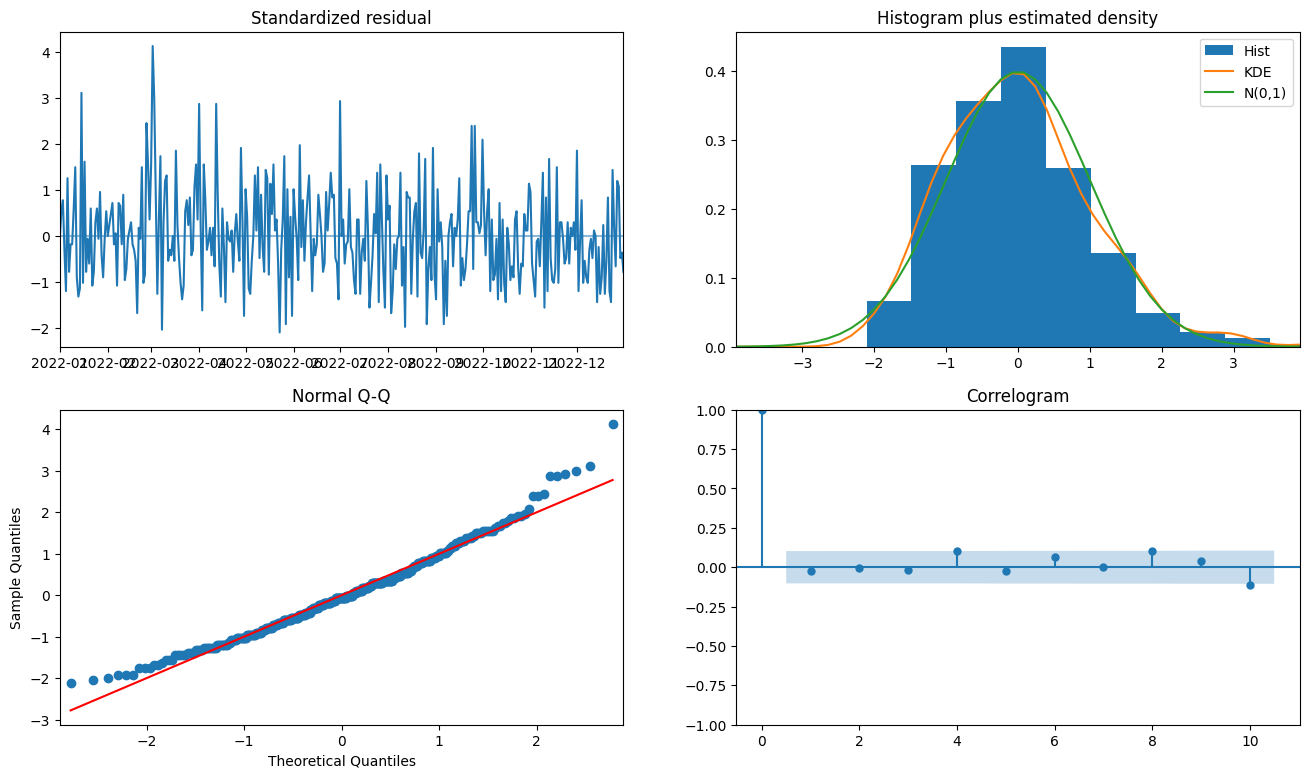

In [29]:
auto_arima.plot_diagnostics(figsize=(16, 9))
plt.show()

#### Manual ARIMA

##### Parameter Estimation

In [30]:
def manual_arima(p, d, q):
    # Create and fit the ARIMA model
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()

    # Make predictions on the test set
    forecast = model_fit.forecast(steps=len(test))

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    return mae, mape, rmse

In [31]:
def optimal_arima(data, p_values, d_values, q_values):
    best_mae = float('inf')
    best_params = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        mae, _, _ = manual_arima(p, d, q)

        if mae < best_mae:
            best_mae = mae
            best_params = (p, d, q)

    return best_params, best_mae

In [32]:
# Define the ranges of p, d, and q values for iteration
p_values = range(0, 5) # Order of Autoregression
d_values = range(0, 5) # Order of Differencing
q_values = range(0, 5) # Order of Moving Average

# Find the optimal ARIMA parameters
optimal_params, optimal_mae = optimal_arima(data_reg, p_values, d_values, q_values)

print('Optimal ARIMA Parameters:')
print(f'p={optimal_params[0]}, d={optimal_params[1]}, q={optimal_params[2]}')

Optimal ARIMA Parameters:
p=0, d=2, q=1


In [33]:
combi = list(itertools.product(p_values, d_values, q_values))

param = []
mae_score = []
mape_score = []
rmse_score = []

for i in combi:
    param.append(i)
    score = manual_arima(*i)
    mae_score.append(score[0])
    mape_score.append(score[1])
    rmse_score.append(score[2])

parameter = pd.DataFrame({'Parameters': param,
                          'MAE': mae_score,
                          'MAPE': mape_score,
                          'RMSE': rmse_score})
parameter.sort_values(by='MAE').reset_index(drop=True).head(1)

,Parameters,MAE,MAPE,RMSE
0,"(0, 2, 1)",11.583143,0.270006,14.542187


In [34]:
# Evaluation metrics for ARIMA(0, 2, 1)
mae, mape, rmse = manual_arima(0, 2, 1)

print(f'MAE : {round(mae, 3)}')
print(f'MAPE: {round(mape, 3)}')
print(f'RMSE: {round(rmse, 3)}')

MAE : 11.583
MAPE: 0.27
RMSE: 14.542


In [35]:
# Split data into training and test sets
train_size = int(len(data_reg) * 0.9175)
train_data, test_data = data_reg[:train_size], data_reg[train_size:]
train_data.shape, test_data.shape

((334, 1), (31, 1))

In [36]:
# Fit ARIMA(0, 2, 1)
model_manual = ARIMA(train, order=(0, 2, 1))
model_manual_fit = model_manual.fit()

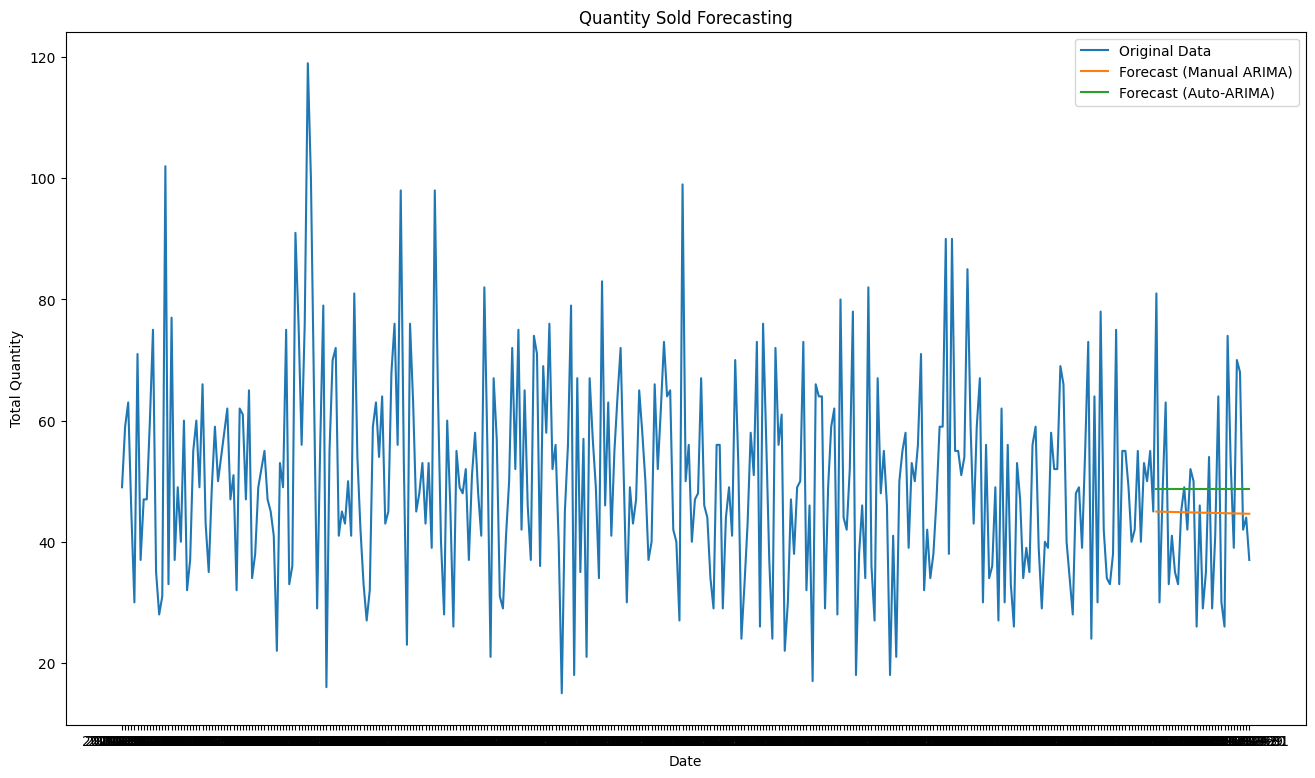

In [37]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# Fit Manual ARIMA model (with p=0, d=3, q=4) on the training data
model_manual = ARIMA(train_data, order=(0, 3, 4))
model_manual = model_manual.fit()
# Forecast using the manual ARIMA model on the test data
forecast_manual = model_manual_fit.forecast(steps=len(test_data))

# Fit Auto-ARIMA model on the training data
model_auto = auto_arima(train_data,
                        start_p=1, start_q=1,
                        max_p=3, max_q=3,
                        m=12,
                        d=None, D=0,
                        seasonal=False)
# Forecast using the Auto-ARIMA model on the test data
forecast_auto = model_auto.predict(n_periods=len(test_data))

# Plot the forecasts
plt.figure(figsize=(16, 9))

plt.plot(data_reg, label='Original Data', color='tab:blue')
plt.plot(test_data.index, forecast_manual, label='Forecast (Manual ARIMA)', color='tab:orange')
plt.plot(test_data.index, forecast_auto, label='Forecast (Auto-ARIMA)', color='tab:green')
plt.title('Quantity Sold Forecasting')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.legend()

plt.show()

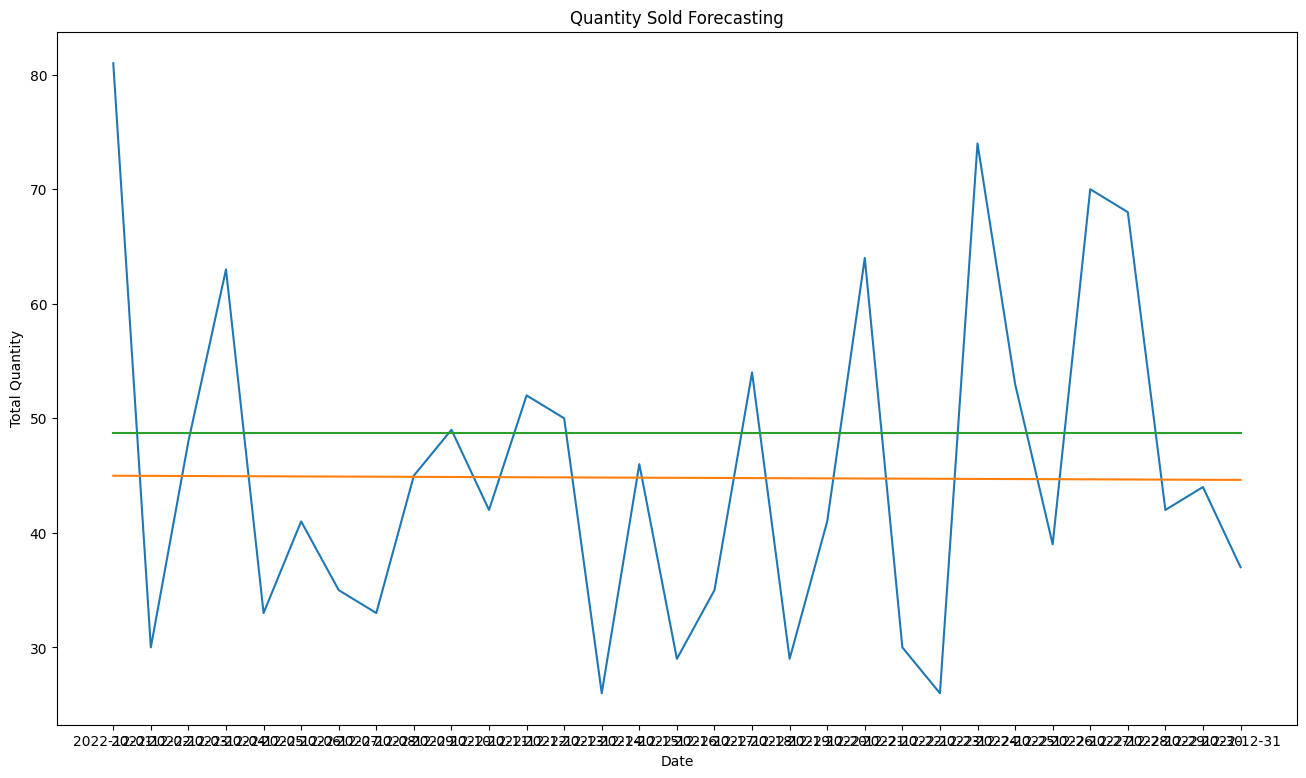

In [38]:
# Plot the forecasts
plt.figure(figsize=(16, 9))

df_plot = data_reg.iloc[train_size:]
df_plot['Forecast (Manual ARIMA)'] = [None] * (len(df_plot) - len(forecast_manual)) + list(forecast_manual)
df_plot['Forecast (Auto-ARIMA)'] = [None] * (len(df_plot) - len(forecast_auto)) + list(forecast_auto)

plt.plot(df_plot)
plt.title('Quantity Sold Forecasting')
plt.xlabel('Date')
plt.ylabel('Total Quantity')

plt.show()

In [39]:
# Auto-ARIMA
mae_auto = mean_absolute_error(test, forecast_auto)
mape_auto = mean_absolute_percentage_error(test, forecast_auto)
rmse_auto = np.sqrt(mean_squared_error(test, forecast_auto))

# Manual ARIMA
mae_manual = mean_absolute_error(test, forecast_manual)
mape_manual = mean_absolute_percentage_error(test, forecast_manual)
rmse_manual = np.sqrt(mean_squared_error(test, forecast_manual))

# Print results
print('Auto-ARIMA  :')
print(f'MAE : {round(mae_auto, 3)}')
print(f'MAPE: {round(mape_auto, 3)}')
print(f'RMSE: {round(rmse_auto, 3)}\n')

print('Manual ARIMA:')
print(f'MAE : {round(mae_manual, 3)}')
print(f'MAPE: {round(mape_manual, 3)}')
print(f'RMSE: {round(rmse_manual, 3)}')

Auto-ARIMA  :
MAE : 12.432
MAPE: 0.312
RMSE: 14.883

Manual ARIMA:
MAE : 11.583
MAPE: 0.27
RMSE: 14.542


🔎 Observasi
- Berdasarkan hasil evaluasi, dapat dilihat bahwa model Manual ARIMA memiliki nilai evaluasi yang jauh lebih baik dibandingkan dengan model Auto-ARIMA.
  - MAE, MAPE, dan RMSE dari model Manual ARIMA jauh lebih kecil, menunjukkan performa yang lebih baik dalam melakukan prediksi.

### Forecasting Overall Quantity

In [40]:
# Apply model
model = ARIMA(data_log, order=(0, 2, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

In [41]:
# # Re-transform data
# data_reg = np.exp(data_log)
# forecast = np.exp(forecast)

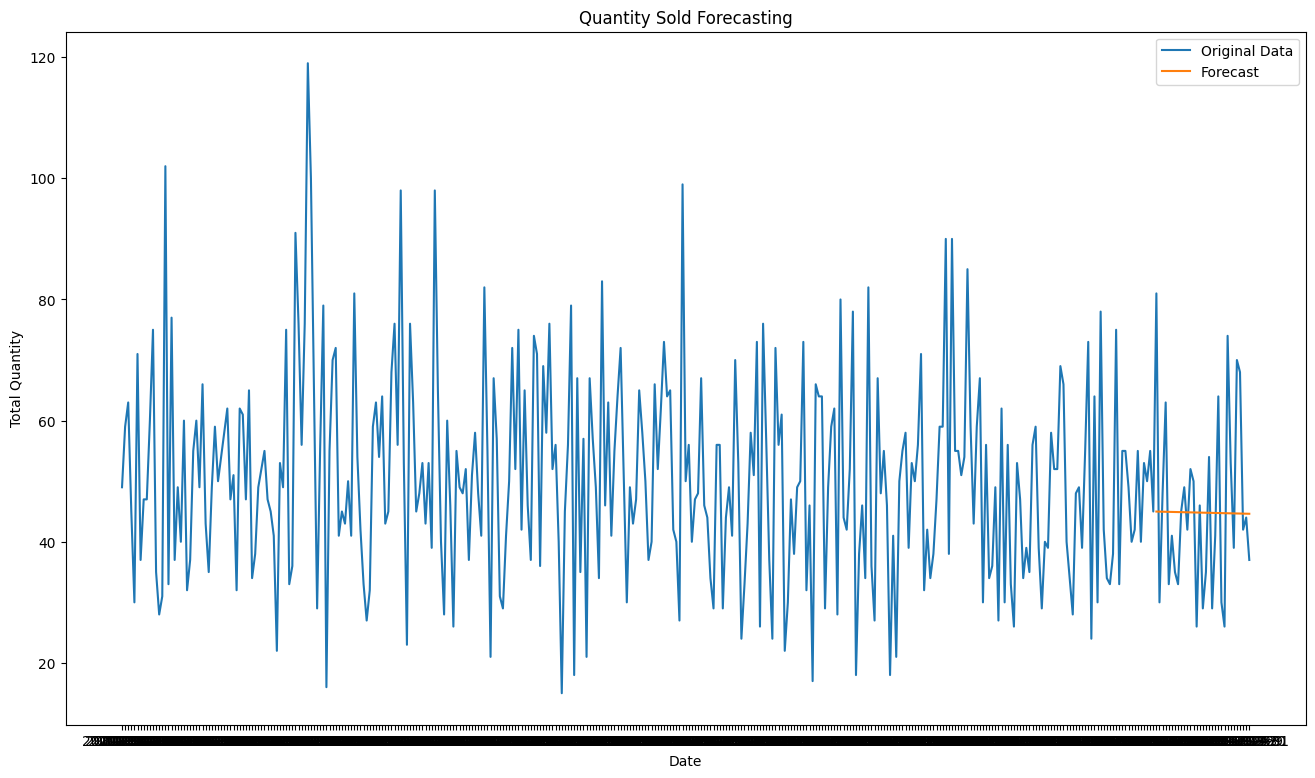

In [42]:
# Plot the forecast
plt.figure(figsize=(16, 9))

plt.plot(data_reg, label='Original Data', color='tab:blue')
plt.plot(test_data.index, forecast_manual, label='Forecast', color='tab:orange')
plt.title('Quantity Sold Forecasting')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.legend()

plt.show()

In [43]:
forecast_manual.mean().round(0)

45.0

🔎 Insight
- Berdasarkan hasil prediksi, dapat disimpulkan bahwa jumlah penjualan bulan depan diperkirakan sekitar 45 buah/hari.

### Forecasting Each Product

In [44]:
data.columns

Index(['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'Income', 'ProductID',
       'ProductName', 'Price', 'StoreID', 'StoreName', 'Group', 'Type',
       'Latitude', 'Longitude', 'TransactionID', 'Date', 'Quantity',
       'TotalAmount'],
      dtype='object')

In [45]:
# Forecast for next 30 days for each product
list_p = data['ProductName'].unique()

df_p = pd.DataFrame({'Date': pd.date_range(start='2023-01-01',
                                           end='2023-01-30')})
df_p = df_p.set_index('Date')
for i in list_p:
    df = data[['Date','ProductName','Quantity']]
    df = data[data['ProductName'] == i]
    df = df.groupby('Date')[['Quantity']].sum()
    df = df.reset_index()

    df['Date'] = pd.to_datetime(df['Date'])

    df_t = pd.DataFrame({'Date': pd.date_range(start='2022-01-01',
                                               end='2022-12-31')})
    df_t = df_t.merge(df,
                      how='left',
                      on='Date')
    df_t = df_t.fillna(0)
    df_t = df_t.set_index('Date')

    model_p = ARIMA(df_t, order=(0, 2, 1))
    model_p_fit = model_p.fit()
    forecast_p = model_p_fit.forecast(steps=30)
    df_p[i] = forecast_p.values

df_p.head()

,Crackers,Oat,Thai Tea,Choco Bar,Coffee Candy,Yoghurt,Ginger Candy,Cheese Stick,Cashew,Potato Chip
Date,,,,,,,,,,
2023-01-01,8.011102,4.005499,-0.009492,-0.030308,12.022602,2.969804,3.994433,5.010680,1.002714,-0.011021
2023-01-02,8.022203,4.010999,-0.018983,-0.060616,12.045204,2.939607,3.988867,5.021361,1.005428,-0.022041
2023-01-03,8.033305,4.016498,-0.028475,-0.090924,12.067807,2.909411,3.983300,5.032041,1.008142,-0.033062
2023-01-04,8.044407,4.021998,-0.037966,-0.121232,12.090409,2.879215,3.977733,5.042721,1.010856,-0.044083
2023-01-05,8.055508,4.027497,-0.047458,-0.151540,12.113011,2.849018,3.972166,5.053402,1.013569,-0.055103


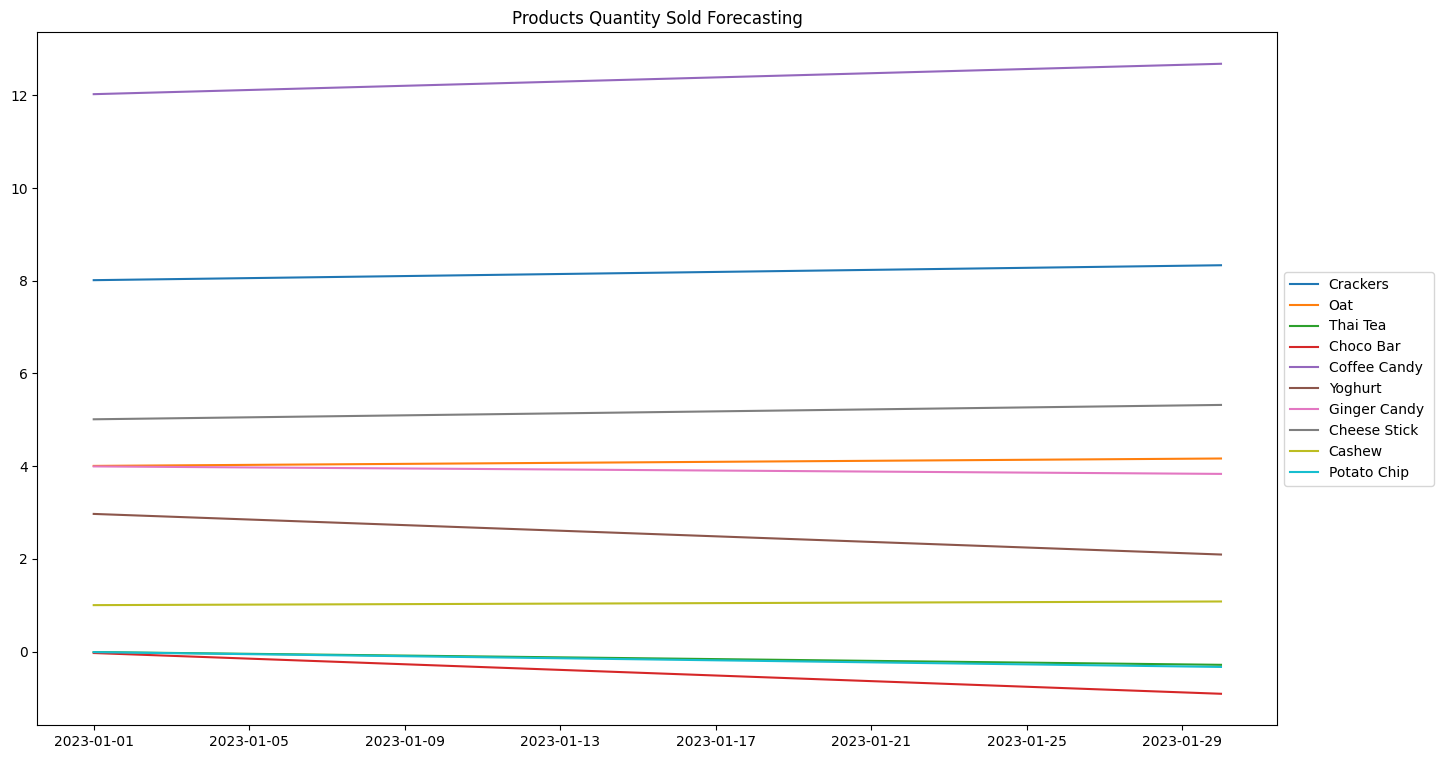

In [46]:
# Plot the forecast
plt.figure(figsize=(16, 9))
plt.plot(df_p)
plt.legend(df_p.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Products Quantity Sold Forecasting')
plt.show()

In [47]:
# Products quantity forecast
round(df_p.describe().T['mean'], 0).astype(int)

Crackers          8
Oat               4
Thai Tea          0
Choco Bar         0
Coffee Candy     12
Yoghurt           3
Ginger Candy      4
Cheese Stick      5
Cashew            1
Potato Chip       0
Name: mean, dtype: int64

🔎 Insight
- Dengan menggunakan data prediksi produk di atas, kita dapat memperoleh estimasi jumlah rata-rata produk yang terjual setiap harinya.